In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from scipy.stats import ttest_1samp

In [2]:
config = json.load(open('../config.json', 'r'))
DATA_DIR = config['DATA_DIR']
TWEET_DIR = config['TWEET_DIR']

In [3]:
events = open(DATA_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(DATA_DIR + "shooters_race.json","r"))

In [4]:
def split_party(part_tweets):
    return part_tweets[part_tweets['dem_follows'] > part_tweets['rep_follows']], part_tweets[part_tweets['dem_follows'] < part_tweets['rep_follows']]

In [5]:
modal_list = []
log_odds_list = []
race = []

def get_odds(tweets,  search):
    total = len(tweets)
    contains = tweets['text'].str.contains(search, case=False).sum()
    return (contains + 1) / ((total - contains) + 1)

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data =  data[~data['remove'] & ~data['isRT']]
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    modal_list.append('MUST')
    log_odds_list.append(np.log(get_odds(rep, r"\bmust[n'’]?\w*\b") / get_odds(dem, r"\bmust[n'’]?\w*\b")))
    race.append(shooter_race[event])
    modal_list.append('SHOULD')
    log_odds_list.append(np.log(get_odds(rep, r"\bshould[n'’]?\w*\b") / get_odds(dem, r"\bshould[n'’]?\w*\b")))
    race.append(shooter_race[event])
    modal_list.append('NEED TO')
    log_odds_list.append(np.log(get_odds(rep, r"\bneed to\b|\bneeds to\b") / get_odds(dem, r"\bneed to\b|\bneeds to\b")))
    race.append(shooter_race[event])    
    modal_list.append('HAVE TO')
    log_odds_list.append(np.log(get_odds(rep, r"\bhas to\b|\bhave to\b") / get_odds(dem, r"\bhas to\b|\bhave to\b")))
    race.append(shooter_race[event])
    

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [6]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'log_odds':log_odds_list, 'race':race})

In [7]:
for i, g in df.groupby('modal'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

HAVE TO
Ttest_1sampResult(statistic=-6.608889419465189, pvalue=1.9483181505360368e-06)
MUST
Ttest_1sampResult(statistic=-4.203676418304983, pvalue=0.00043694623689948805)
NEED TO
Ttest_1sampResult(statistic=-3.033095955178946, pvalue=0.0065672893980417086)
SHOULD
Ttest_1sampResult(statistic=-3.0886248018459046, pvalue=0.005792319868196137)


In [8]:
df.groupby('modal').median().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.392316
MUST,-0.209859
SHOULD,-0.161042
NEED TO,-0.128364


In [9]:
df.groupby('modal').mean().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.385567
MUST,-0.276668
SHOULD,-0.184487
NEED TO,-0.177741


[None, None]

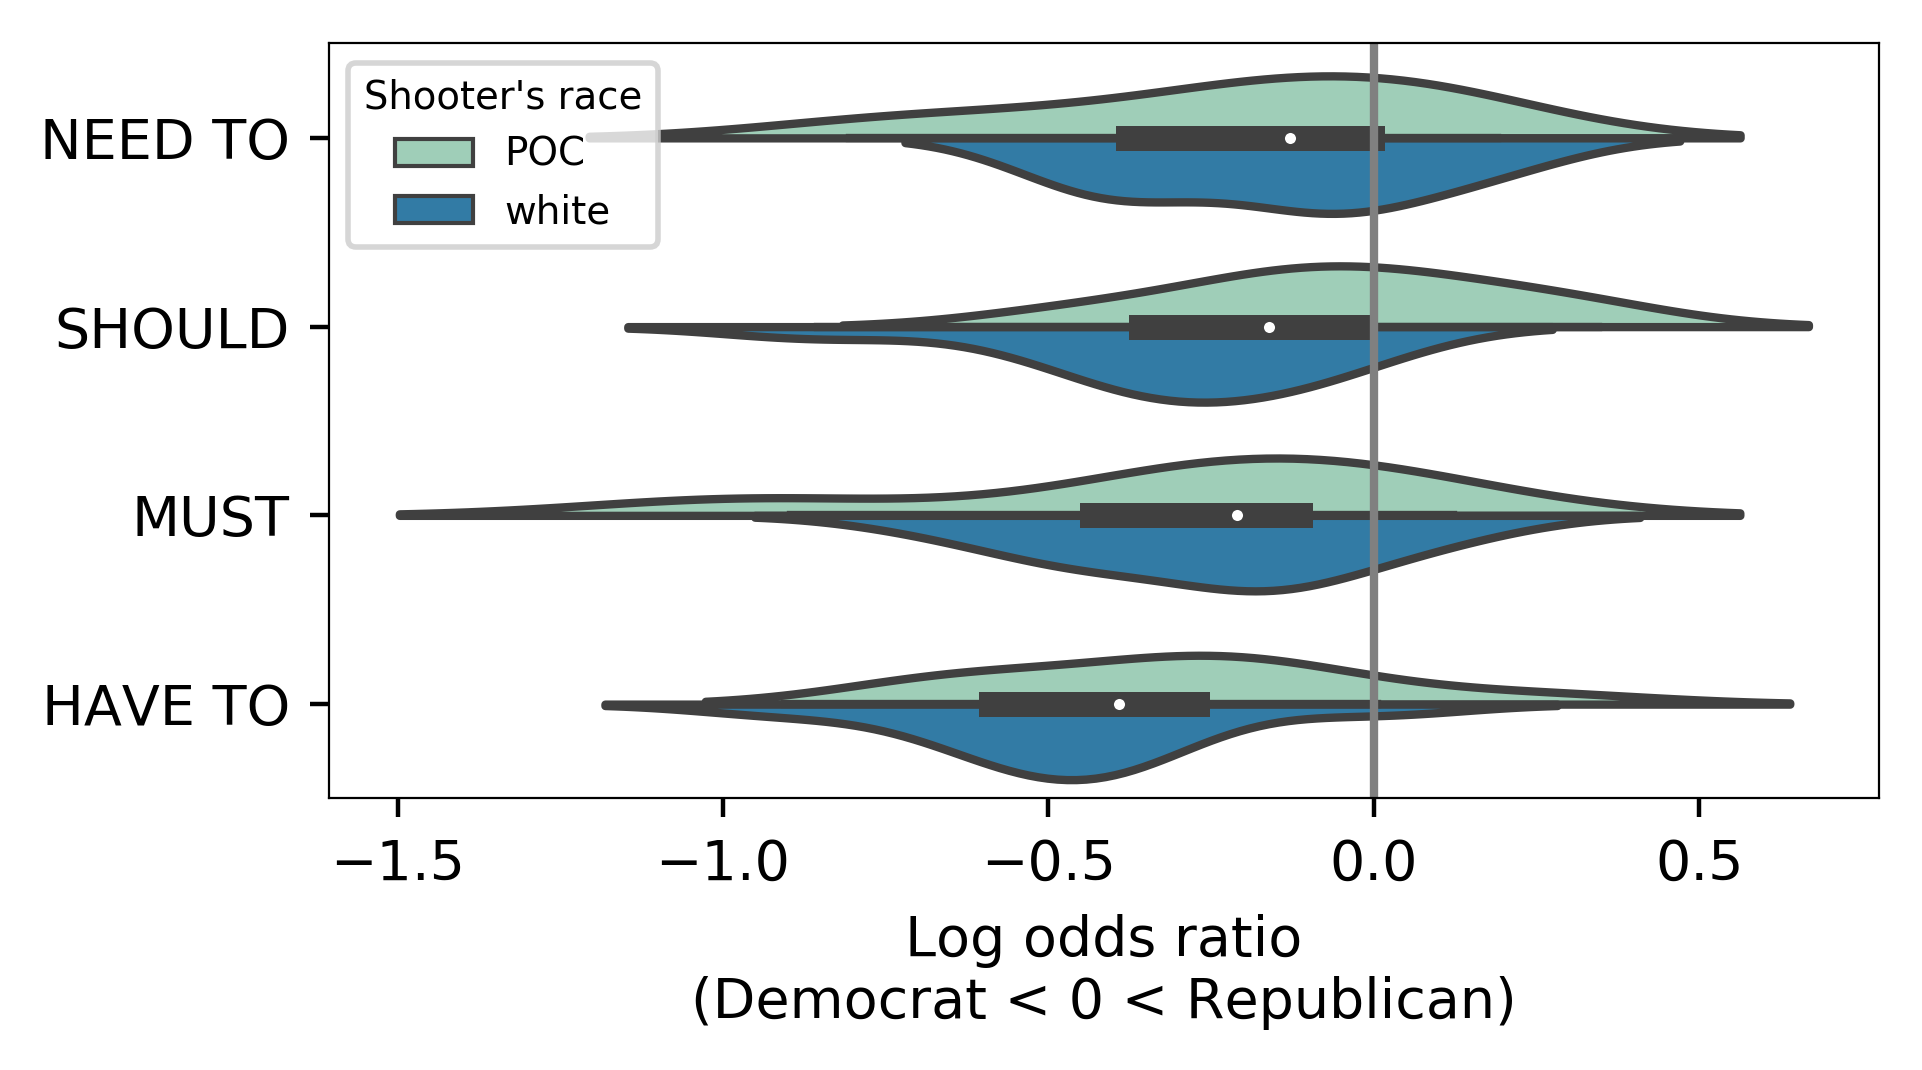

In [11]:
f = plt.figure(dpi=400, figsize=(5,2.5))
ax = sns.violinplot(data=df, x="log_odds",y="modal", hue='race', fliersize=1, split=True, order=reversed(df.groupby('modal').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.axvline(x=0, color='grey')
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
legend = ax.legend(loc='upper left', title="Shooter's race", fontsize=7)
plt.setp(legend.get_title(),fontsize='x-small')